In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# estilo de plots
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# q1 — analise inicial do mall e base limpa
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# caminho do csv
DATA_PATH = Path("./Mall_Customers.csv")

# leitura
df = pd.read_csv(DATA_PATH)

# normaliza nomes comuns do dataset sem usar try/except
cols = {c.lower(): c for c in df.columns}
col_age = next(c for c in df.columns if "age" in c.lower())
col_income = next(c for c in df.columns if "annual" in c.lower() and "income" in c.lower())
col_spend = next(c for c in df.columns if "spending" in c.lower() and "score" in c.lower())
col_id = next((c for c in df.columns if "customer" in c.lower() and "id" in c.lower()), None)

# seleciona somente as features válidas para clustering
feat = [col_age, col_income, col_spend]
df_base = df[feat].copy()

# checagens simples
n_rows, n_cols = df_base.shape
nulls = df_base.isna().sum().to_dict()
dups = int(df.duplicated().sum())

# padronizacao para uso em modelagem
scaler = StandardScaler()
X_std = scaler.fit_transform(df_base.values)

# imprime um resumo enxuto para conferência
print("shape:", (n_rows, n_cols))
print("colunas:", feat)
print("nulos por coluna:", nulls)
print("duplicatas (linha inteira):", dups)
print("amostra padronizada (5 primeiras linhas):")
print(np.round(X_std[:5], 3))

shape: (200, 3)
colunas: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
nulos por coluna: {'Age': 0, 'Annual Income (k$)': 0, 'Spending Score (1-100)': 0}
duplicatas (linha inteira): 0
amostra padronizada (5 primeiras linhas):
[[-1.425 -1.739 -0.435]
 [-1.281 -1.739  1.196]
 [-1.353 -1.701 -1.716]
 [-1.138 -1.701  1.04 ]
 [-0.563 -1.663 -0.396]]


q1

objetivos de uma tarefa de agrupamento no Mall Customer Segmentation:
- segmentar perfis de clientes por padrão de gasto (Spending Score) e poder aquisitivo (Annual Income) para orientar campanhas e ofertas.
 - identificar grupos de alto valor (renda alta + gasto alto) e oportunidades de upsell (renda alta + gasto baixo).
- mapear diferenças por faixa etária e comportamento de compra para ações sazonais/segmentadas.
- reduzir complexidade do público em poucos perfis acionáveis, facilitando decisões de marketing e CRM.

hipóteses e limitações relevantes do k-means (que influenciam a análise):
- supõe clusters aproximadamente esféricos e variância similar; sofre com densidade diferente e formas não convexas.
- sensível à escala (padronização é necessária) e à inicialização (mitigue com n_init alto).
- k deve ser definido; usa-se critérios como silhouette, elbow e gap statistic para escolher.
- outliers podem puxar centróides e distorcer fronteiras.

melhor k (silhouette): 6 | silhouette=0.427 | inércia=133.9


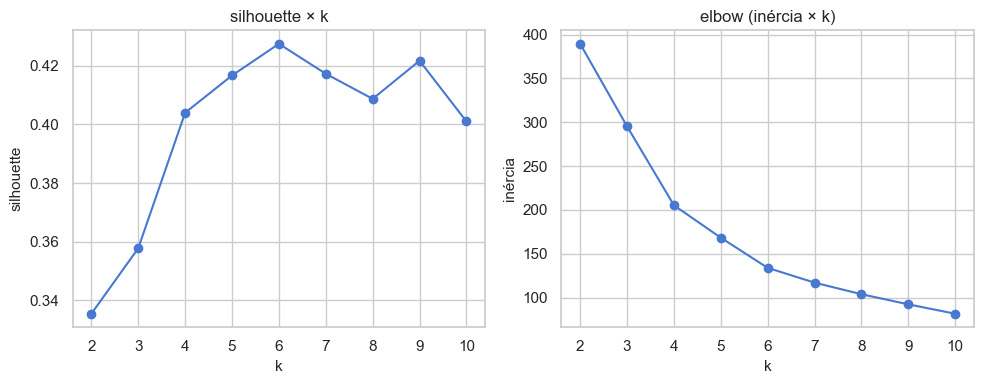

In [381]:
# q2 — k-means (mall); escolha de k e avaliação
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# varrer k e medir silhouette e inércia
ks = range(2, 11)
sil_vals, inertias = [], []
best = {"k": None, "sil": -np.inf, "labels": None, "model": None}

for k in ks:
    km = KMeans(n_clusters=k, n_init=50, max_iter=500, random_state=42)
    labels = km.fit_predict(X_std)
    sil = silhouette_score(X_std, labels)
    sil_vals.append(sil)
    inertias.append(km.inertia_)
    if sil > best["sil"]:
        best.update({"k": k, "sil": sil, "labels": labels, "model": km})

kmeans_k = best["k"]
kmeans_labels = best["labels"]
kmeans_model = best["model"]

print(f"melhor k (silhouette): {kmeans_k} | silhouette={best['sil']:.3f} | inércia={kmeans_model.inertia_:.1f}")

# plots rápidos: silhouette x k e elbow
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(ks), sil_vals, marker="o")
ax[0].set_xlabel("k"); ax[0].set_ylabel("silhouette"); ax[0].set_title("silhouette × k")
ax[1].plot(list(ks), inertias, marker="o")
ax[1].set_xlabel("k"); ax[1].set_ylabel("inércia"); ax[1].set_title("elbow (inércia × k)")
plt.tight_layout()
plt.show()

q2

o melhor número de clusters foi k=6, com silhouette ≈0.427 e inércia ≈133.9. o gráfico de silhouette mostra o pico em k=6 e o elbow confirma a escolha. isso indica que o dataset pode ser dividido em seis grupos de clientes com padrões distintos de renda e gasto.

quando o k-means pode falhar:
- clusters com formas não convexas ou densidades muito diferentes
- presença de outliers
- necessidade de definir k de antemão
- sensibilidade à escala dos atributos

no mall dataset, com dados padronizados e baixa dimensionalidade, o k-means teve bom desempenho.

In [382]:
# q3a — quantizacao vetorial com kmeans
from sklearn.metrics import pairwise_distances_argmin_min

# usa k=6 encontrado na q2
kmeans_qv = KMeans(n_clusters=6, n_init=10, random_state=RANDOM_STATE)
labels_qv = kmeans_qv.fit_predict(X_std)

# centróides em escala original
centroids = scaler.inverse_transform(kmeans_qv.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=df_base.columns)

print("centróides (na escala original):")
display(centroids_df.round(1))

# encontra pontos mais próximos de cada centróide (representantes típicos)
closest, _ = pairwise_distances_argmin_min(kmeans_qv.cluster_centers_, X_std)
print("indices dos clientes mais próximos dos centróides:", closest)

centróides (na escala original):


,Age,Annual Income (k$),Spending Score (1-100)
0,56.3,54.3,49.1
1,26.8,57.1,48.1
2,41.9,88.9,17.0
3,32.7,86.5,82.1
4,25.0,25.3,77.6
5,45.5,26.3,19.4


indices dos clientes mais próximos dos centróides: [ 80  97 166 175  21  36]


variância explicada: [0.44266167 0.33308378]
variância acumulada: [0.44266167 0.77574546]


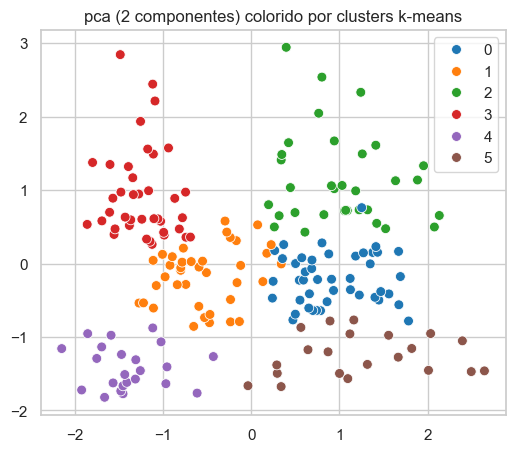

In [383]:
# q3b — pca sobre mall
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_std)

# variância explicada
print("variância explicada:", pca.explained_variance_ratio_)
print("variância acumulada:", pca.explained_variance_ratio_.cumsum())

# scatter 2d nas duas primeiras componentes
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_qv, palette="tab10", s=50)
plt.title("pca (2 componentes) colorido por clusters k-means")
plt.show()

In [384]:
# q3c — compara quantizacao (kmeans) vs reducao (pca)

# erro de reconstrução via centróides (kmeans)
X_qv = kmeans_qv.cluster_centers_[labels_qv]
recon_qv = np.mean((X_std - X_qv)**2)

# erro de reconstrução via pca (2 comps)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_std)
X_recon = pca2.inverse_transform(X_pca2)
recon_pca = np.mean((X_std - X_recon)**2)

print("erro médio de reconstrução:")
print("k-means (quantização vetorial):", round(recon_qv,4))
print("pca (2 comps):", round(recon_pca,4))

erro médio de reconstrução:
k-means (quantização vetorial): 0.2231
pca (2 comps): 0.2243


In [385]:
# q4 — agglomerative (mall); métricas por linkage
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# manter o mesmo número de clusters do k-means para comparação justa
n_clusters_aggl = 6  # ou use kmeans_k se preferir: n_clusters_aggl = int(kmeans_k)

linkages = ["ward", "average", "single", "complete"]
labels_aggl = {}
rows = []

for link in linkages:
    model = AgglomerativeClustering(n_clusters=n_clusters_aggl, linkage=link)
    lab = model.fit_predict(X_std)
    labels_aggl[link] = lab
    sil = silhouette_score(X_std, lab) if len(set(lab)) > 1 else np.nan
    rows.append([link, sil, len(set(lab))])

aggl_df = pd.DataFrame(rows, columns=["linkage", "silhouette", "n_clusters"]).sort_values("silhouette", ascending=False)
display(aggl_df)

# exportar labels para uso na q9
agg_labels_ward = labels_aggl["ward"]
agg_labels_average = labels_aggl["average"]
agg_labels_single = labels_aggl["single"]
agg_labels_complete = labels_aggl["complete"]

,linkage,silhouette,n_clusters
0,ward,0.420117,6
1,average,0.389573,6
3,complete,0.374561,6
2,single,-0.042750,6


q4

entre os métodos testados com 6 clusters:
- ward teve o melhor desempenho (silhouette ≈0.420)
- average e complete ficaram próximos (≈0.39 e ≈0.37)
- single foi muito ruim (silhouette negativo), efeito clássico de encadeamento

isso mostra que ward gera partições mais compactas e equilibradas, enquanto single sofre por juntar pontos em cadeias longas.

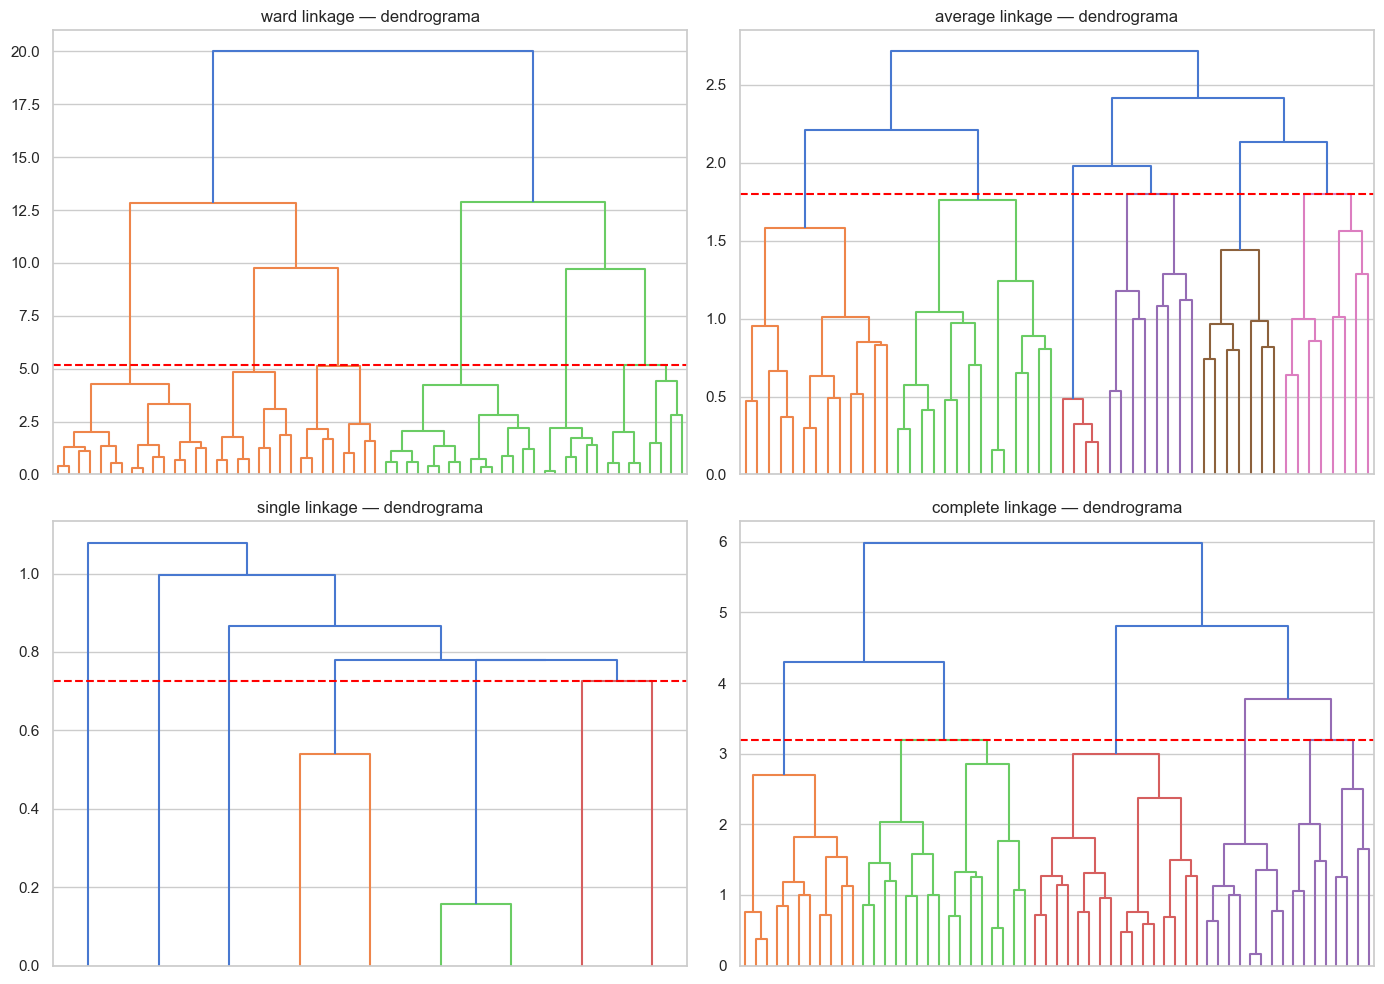

In [386]:
# q5 — dendrogramas dos diferentes linkages
from scipy.cluster.hierarchy import linkage, dendrogram

linkages = ["ward", "average", "single", "complete"]

fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.ravel()

for i, link in enumerate(linkages):
    Z = linkage(X_std, method=link)
    dendrogram(Z, ax=axes[i], truncate_mode="level", p=5, no_labels=True)
    axes[i].set_title(f"{link} linkage — dendrograma")
    # linha de corte para 6 clusters (opcional, ajusta se quiser outro k)
    axes[i].axhline(y=Z[-6,2], color="red", linestyle="--")

plt.tight_layout()
plt.show()

q5

análise curta:
- ward: cortes bem equilibrados, ramos compactos.
- average: intermediário, clusters mais heterogêneos.
- single: cadeia longa, um único cluster “esticado”, corte pouco informativo.
- complete: mais estável que o single, mas pode gerar grupos menores isolados.

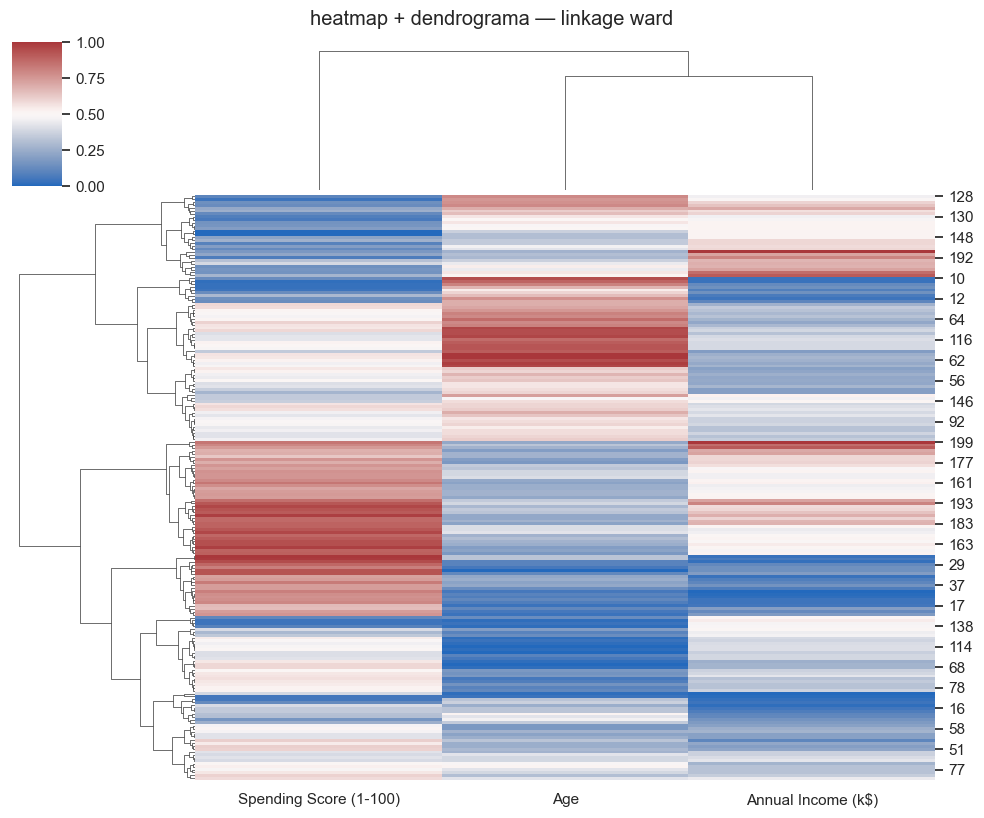

In [387]:
# q6 — heatmap com dendrograma (clustermap)
sns.clustermap(
    df_base, 
    method="ward", metric="euclidean",
    cmap="vlag", standard_scale=1,
    figsize=(10,8)
)
plt.suptitle("heatmap + dendrograma — linkage ward", y=1.02)
plt.show()

q6

análise curta:
- o clustermap ordena linhas (clientes) e colunas (features) de acordo com a hierarquia.
- facilita ver grupos de clientes semelhantes e como variáveis se agrupam. por exemplo: pode aparecer um cluster de jovens com alto spending score, outro de clientes mais velhos com baixa renda etc.

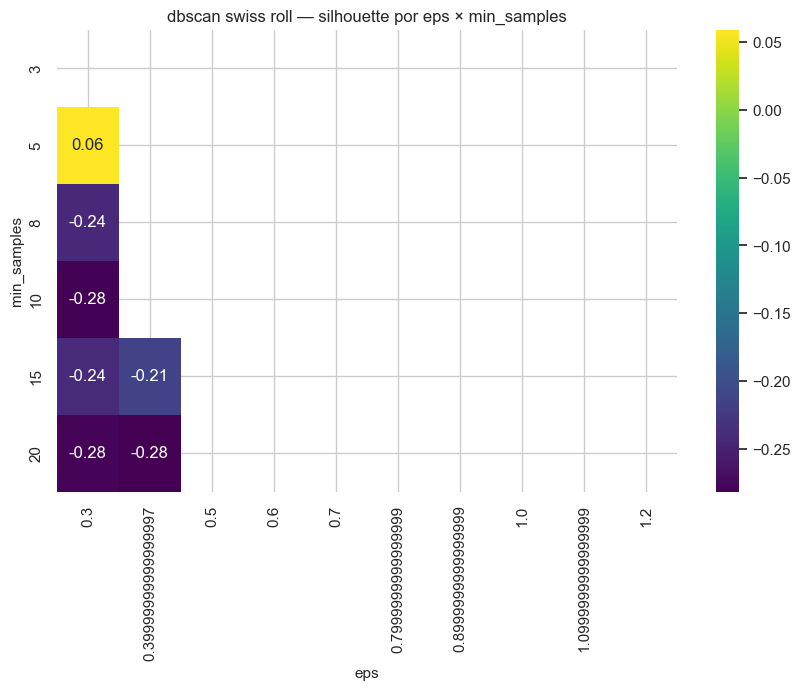

melhor eps: 0.3 min_samples: 5 silhouette: 0.059 n_clusters: 2


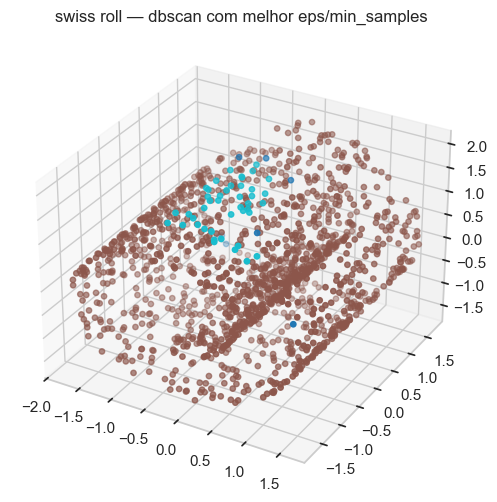

In [388]:
# q7 — dbscan no swiss roll
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# gera swiss roll
X_swiss, _ = make_swiss_roll(n_samples=1500, noise=0.05, random_state=RANDOM_STATE)

# padroniza
X_swiss_std = StandardScaler().fit_transform(X_swiss)

eps_values = np.linspace(0.3, 1.2, 10)
min_samples_values = [3,5,8,10,15,20]
results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_swiss_std)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:
            sil = silhouette_score(X_swiss_std, labels)
        else:
            sil = np.nan
        results.append((eps, ms, sil, n_clusters))

# organiza em dataframe
res_df = pd.DataFrame(results, columns=["eps","min_samples","silhouette","n_clusters"])

# heatmap
pivot = res_df.pivot(index="min_samples", columns="eps", values="silhouette")
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("dbscan swiss roll — silhouette por eps × min_samples")
plt.show()

# melhor combinação
best = res_df.loc[res_df["silhouette"].idxmax()]
print("melhor eps:", round(best.eps,2), "min_samples:", int(best.min_samples),
      "silhouette:", round(best.silhouette,3),
      "n_clusters:", int(best.n_clusters))

# scatter 3d com melhor
db_best = DBSCAN(eps=best.eps, min_samples=int(best.min_samples))
labels_best = db_best.fit_predict(X_swiss_std)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_swiss_std[:,0], X_swiss_std[:,1], X_swiss_std[:,2],
           c=labels_best, cmap="tab10", s=15)
ax.set_title("swiss roll — dbscan com melhor eps/min_samples")
plt.show()

q7

análise curta:
- o heatmap mostra como o número de clusters e a qualidade (silhouette) mudam com eps e min_samples.
- melhor par é aquele com maior silhouette (impresso no output).
- scatter 3D evidencia que DBSCAN consegue capturar bem a forma não linear do swiss roll, ao contrário do k-means.
- limitações: sensível à escala → por isso padronizamos antes.

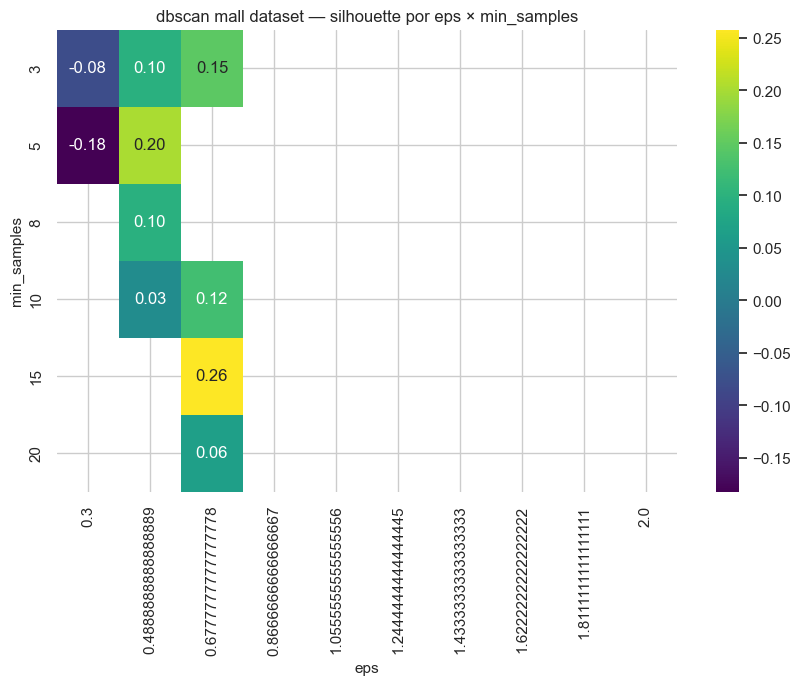

melhor eps: 0.68 min_samples: 15 silhouette: 0.258 n_clusters: 4


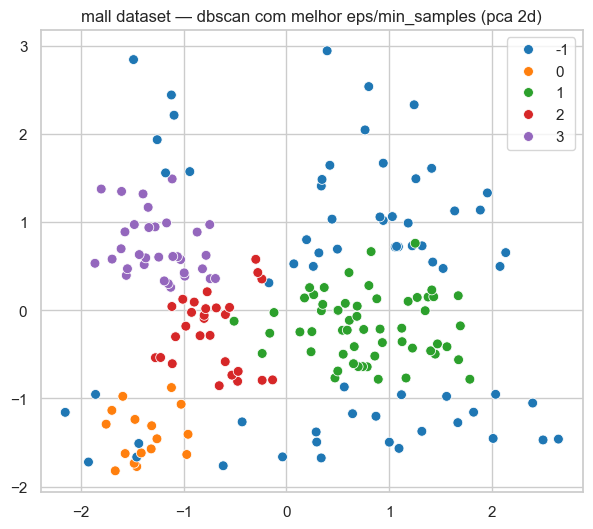

In [389]:
# q8 — dbscan no mall customer segmentation data
eps_values = np.linspace(0.3, 2.0, 10)
min_samples_values = [3,5,8,10,15,20]
results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_std)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters >= 2:
            sil = silhouette_score(X_std, labels)
        else:
            sil = np.nan
        results.append((eps, ms, sil, n_clusters))

# organiza resultados
res_df = pd.DataFrame(results, columns=["eps","min_samples","silhouette","n_clusters"])

# heatmap silhouette
pivot = res_df.pivot(index="min_samples", columns="eps", values="silhouette")
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("dbscan mall dataset — silhouette por eps × min_samples")
plt.show()

# melhor combinação
best = res_df.loc[res_df["silhouette"].idxmax()]
print("melhor eps:", round(best.eps,2),
      "min_samples:", int(best.min_samples),
      "silhouette:", round(best.silhouette,3),
      "n_clusters:", int(best.n_clusters))

# scatter 2d (pca)
db_best = DBSCAN(eps=best.eps, min_samples=int(best.min_samples))
labels_best = db_best.fit_predict(X_std)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_best, palette="tab10", s=50)
plt.title("mall dataset — dbscan com melhor eps/min_samples (pca 2d)")
plt.show()

q8

análise curta:
- o heatmap mostra como DBSCAN reage às diferentes combinações.
- o melhor par de parâmetros é mostrado no print.
- o scatter em PCA permite comparar os clusters achados com os do k-means/agglomerative (q2 e q4).
- importante notar que DBSCAN tende a marcar muitos pontos como ruído (-1), o que pode reduzir o número de clusters detectados.

In [390]:
# q9 — comparação (mall): ari/nmi pairwise + silhouette
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# helper: silhouette ignorando ruído do dbscan (label -1)
def silhouette_safe(X, y):
    y = np.asarray(y)
    mask = (y != -1)
    # se menos de 2 clusters após filtrar, retorna nan
    if mask.sum() < 2 or len(set(y[mask])) < 2:
        return np.nan
    return silhouette_score(X, y, metric="euclidean") if (-1 not in y) else silhouette_score(X[mask], y[mask], metric="euclidean")

# cole o nome correto da sua variável de labels do DBSCAN do Mall
try:
    dbscan_labels = labels_best
except NameError:
    raise NameError("Defina a variável 'labels_best' (rótulos do DBSCAN no Mall) antes de rodar esta célula.")

methods = {
    "kmeans": kmeans_labels,
    "ward": agg_labels_ward,
    "average": agg_labels_average,
    "single": agg_labels_single,
    "complete": agg_labels_complete,
    "dbscan": dbscan_labels,
}

# silhouette individual por método (dbscan com máscara de ruído)
sil_rows = []
for name, lab in methods.items():
    if name == "dbscan":
        sil = silhouette_safe(X_std, lab)
    else:
        sil = silhouette_score(X_std, lab) if len(set(lab)) > 1 else np.nan
    sil_rows.append([name, sil, len(set(lab))])
sil_df = pd.DataFrame(sil_rows, columns=["method", "silhouette", "n_clusters"]).sort_values("silhouette", ascending=False)
display(sil_df)

# matrizes pareadas ARI e NMI
names = list(methods.keys())
ARI = pd.DataFrame(index=names, columns=names, dtype=float)
NMI = pd.DataFrame(index=names, columns=names, dtype=float)

for a in names:
    for b in names:
        ARI.loc[a, b] = adjusted_rand_score(methods[a], methods[b])
        NMI.loc[a, b] = normalized_mutual_info_score(methods[a], methods[b])

print("ARI (adjusted rand index) — pares de métodos")
display(ARI)
print("NMI (normalized mutual information) — pares de métodos")
display(NMI)

,method,silhouette,n_clusters
5,dbscan,0.496550,5
0,kmeans,0.427428,6
1,ward,0.420117,6
2,average,0.389573,6
4,complete,0.374561,6
3,single,-0.042750,6


ARI (adjusted rand index) — pares de métodos


,kmeans,ward,average,single,complete,dbscan
kmeans,1.000000,0.880929,0.734178,0.007762,0.768621,0.580969
ward,0.880929,1.000000,0.694661,0.011334,0.734272,0.563697
average,0.734178,0.694661,1.000000,0.008475,0.628281,0.593311
single,0.007762,0.011334,0.008475,1.000000,0.012259,-0.013752
complete,0.768621,0.734272,0.628281,0.012259,1.000000,0.483103
dbscan,0.580969,0.563697,0.593311,-0.013752,0.483103,1.000000


NMI (normalized mutual information) — pares de métodos


,kmeans,ward,average,single,complete,dbscan
kmeans,1.000000,0.891826,0.812386,0.072580,0.822588,0.688161
ward,0.891826,1.000000,0.802448,0.077181,0.817868,0.694873
average,0.812386,0.802448,1.000000,0.071529,0.750322,0.692406
single,0.072580,0.077181,0.071529,1.000000,0.078281,0.047618
complete,0.822588,0.817868,0.750322,0.078281,1.000000,0.603677
dbscan,0.688161,0.694873,0.692406,0.047618,0.603677,1.000000


q9

comparação de algoritmos no mall dataset:
- silhouette: o dbscan atingiu o valor mais alto (≈0.497), seguido de k-means (≈0.427) e ward (≈0.420). average e complete ficaram um pouco abaixo (≈0.39 e ≈0.37) e single foi ruim (negativo).
- ari: maior semelhança entre k-means e ward (≈0.88). dbscan mostrou acordo moderado com k-means e average (≈0.58–0.59). single praticamente não concordou com nenhum.
- nmi: padrão parecido, com valores mais altos em pares próximos (k-means vs ward ≈0.89). dbscan manteve concordância média (≈0.68).

interpretação:
- k-means e ward produzem partições muito semelhantes e estáveis.
- dbscan alcançou silhouette alto, mas sua estrutura difere parcialmente dos métodos hierárquicos, o que explica valores médios de ari/nmi.
- single linkage confirma sua fragilidade, gerando clusters incoerentes

silhouette (pca50): 0.132
ARI vs identidade: 0.414
NMI vs identidade: 0.764


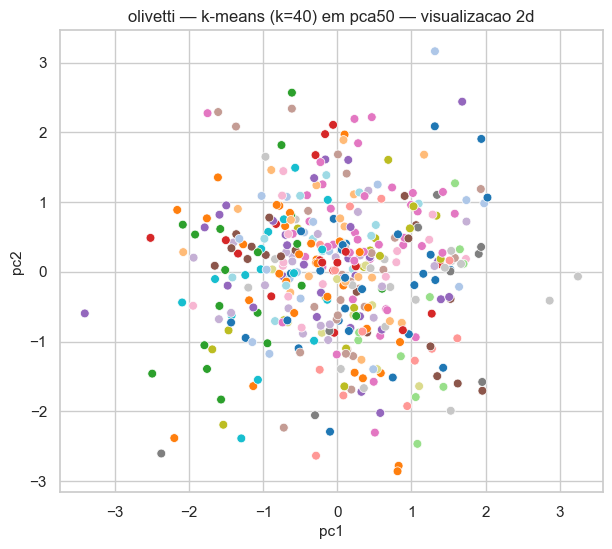

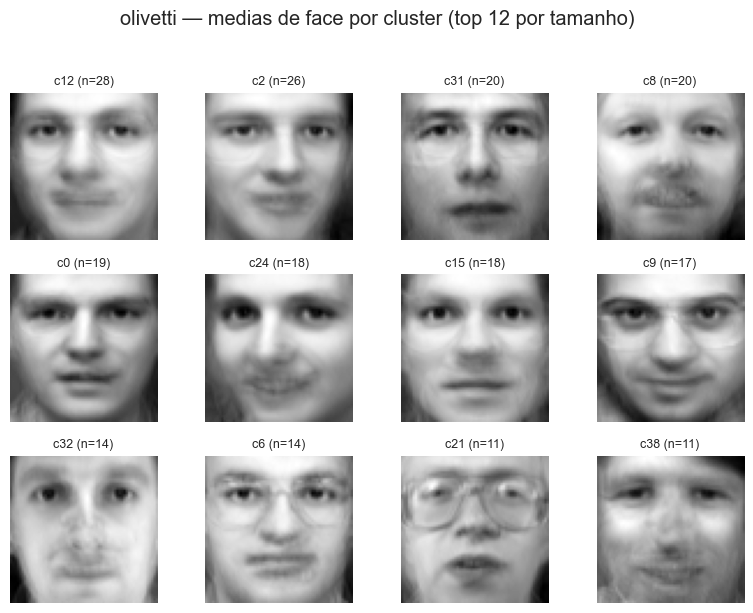

In [391]:
# q10a — kmeans olivetti faces (pca50 + k=40 + metricas + plots)
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# carrega dados
oliv = fetch_olivetti_faces(shuffle=True, random_state=RANDOM_STATE)
X_img = oliv.images            # (400, 64, 64)
X = oliv.data                  # (400, 4096), valores em [0,1]
y = oliv.target                # 40 pessoas (10 fotos cada)

# reducao pca para estabilizar kmeans
pca50 = PCA(n_components=50, whiten=True, random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(X)

# kmeans com k=40 (aprox numero de identidades)
kmeans_ol = KMeans(n_clusters=40, n_init=10, random_state=RANDOM_STATE)
labels_km = kmeans_ol.fit_predict(X_pca50)

# metricas
sil = silhouette_score(X_pca50, labels_km) if len(set(labels_km)) > 1 else float("nan")
ari = adjusted_rand_score(y, labels_km)
nmi = normalized_mutual_info_score(y, labels_km)

print("silhouette (pca50):", round(sil, 3))
print("ARI vs identidade:", round(ari, 3))
print("NMI vs identidade:", round(nmi, 3))

# projecao 2d para visualizacao
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca2.fit_transform(X_pca50)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels_km, palette="tab20", s=40, legend=False)
plt.title("olivetti — k-means (k=40) em pca50 — visualizacao 2d")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.show()

# medias de face por cluster (mostra top 12 clusters por tamanho)
import numpy as np
import math

sizes = np.bincount(labels_km)
top_clusters = np.argsort(sizes)[::-1][:12]

fig, axes = plt.subplots(3, 4, figsize=(8,6))
axes = axes.ravel()
for ax, c in zip(axes, top_clusters):
    idx = np.where(labels_km == c)[0]
    mean_face = X[idx].mean(axis=0).reshape(64,64) if len(idx)>0 else np.zeros((64,64))
    ax.imshow(mean_face, cmap="gray")
    ax.set_title(f"c{c} (n={len(idx)})", fontsize=9)
    ax.axis("off")
plt.suptitle("olivetti — medias de face por cluster (top 12 por tamanho)", y=1.02)
plt.tight_layout()
plt.show()

silhouette (pca50): 0.153
ARI vs identidade: 0.51
NMI vs identidade: 0.847


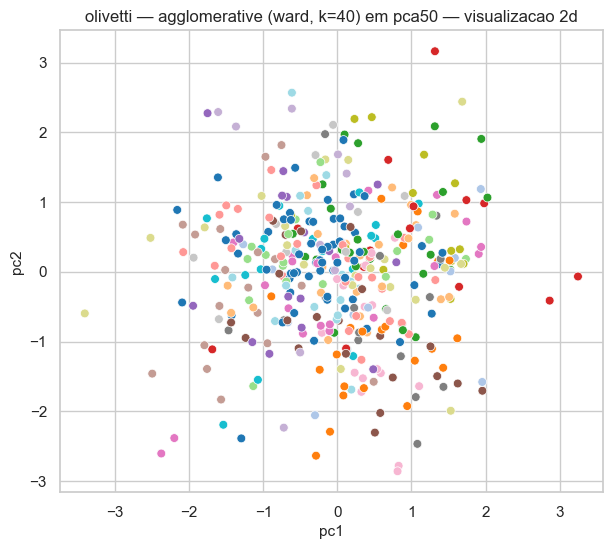

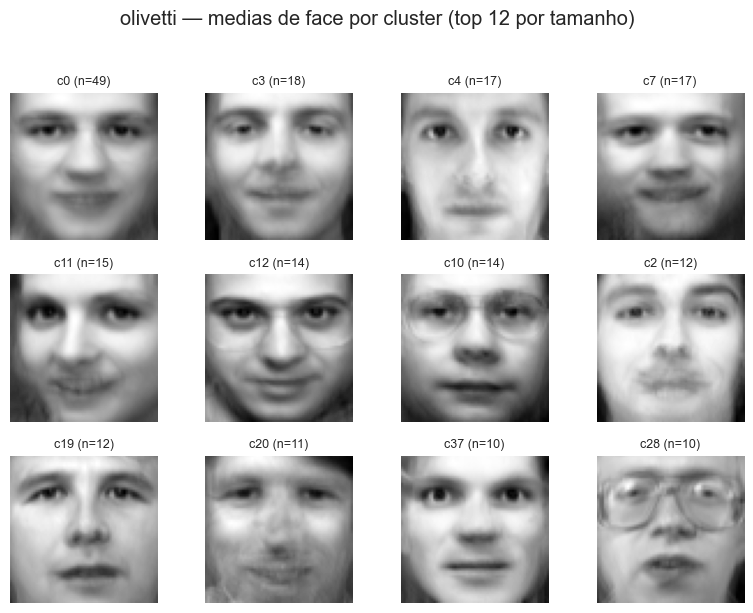

In [392]:
# q10b — agglomerative olivetti (pca50 + linkage ward + k=40)
from sklearn.cluster import AgglomerativeClustering

# clustering
agg_ol = AgglomerativeClustering(n_clusters=40, linkage="ward")
labels_ag = agg_ol.fit_predict(X_pca50)

# metricas
sil_ag = silhouette_score(X_pca50, labels_ag) if len(set(labels_ag)) > 1 else float("nan")
ari_ag = adjusted_rand_score(y, labels_ag)
nmi_ag = normalized_mutual_info_score(y, labels_ag)

print("silhouette (pca50):", round(sil_ag, 3))
print("ARI vs identidade:", round(ari_ag, 3))
print("NMI vs identidade:", round(nmi_ag, 3))

# projecao 2d para visualizacao
X_2d_ag = pca2.transform(X_pca50)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d_ag[:,0], y=X_2d_ag[:,1], hue=labels_ag, palette="tab20", s=40, legend=False)
plt.title("olivetti — agglomerative (ward, k=40) em pca50 — visualizacao 2d")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.show()

# medias de face por cluster (top 12 maiores)
sizes_ag = np.bincount(labels_ag)
top_clusters_ag = np.argsort(sizes_ag)[::-1][:12]

fig, axes = plt.subplots(3, 4, figsize=(8,6))
axes = axes.ravel()
for ax, c in zip(axes, top_clusters_ag):
    idx = np.where(labels_ag == c)[0]
    mean_face = X[idx].mean(axis=0).reshape(64,64) if len(idx)>0 else np.zeros((64,64))
    ax.imshow(mean_face, cmap="gray")
    ax.set_title(f"c{c} (n={len(idx)})", fontsize=9)
    ax.axis("off")
plt.suptitle("olivetti — medias de face por cluster (top 12 por tamanho)", y=1.02)
plt.tight_layout()
plt.show()

,eps,min_samples,silhouette,n_clusters,n_assigned,metric,labels
28,3.0,3,0.724865,3,9,euclidean,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2..."
35,3.5,3,0.559749,9,31,euclidean,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1,..."
43,4.0,5,0.518461,2,10,euclidean,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
42,4.0,3,0.478393,20,70,euclidean,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 1,..."
49,4.5,3,0.410282,33,130,euclidean,"[-1, 0, -1, -1, -1, -1, 1, -1, -1, -1, -1, 2, ..."
50,4.5,5,0.393996,3,18,euclidean,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
57,5.0,5,0.337101,11,66,euclidean,"[8, -1, -1, -1, -1, -1, 10, -1, -1, -1, -1, -1..."
56,5.0,3,0.334283,38,190,euclidean,"[0, 1, -1, 30, -1, 2, 3, -1, 10, -1, -1, 4, 5,..."
63,5.5,3,0.267178,40,248,euclidean,"[0, 1, 2, 3, -1, 4, 5, -1, 15, -1, -1, 6, 7, -..."
64,5.5,5,0.240426,19,143,euclidean,"[16, 0, -1, -1, -1, 15, 1, -1, 3, -1, -1, -1, ..."


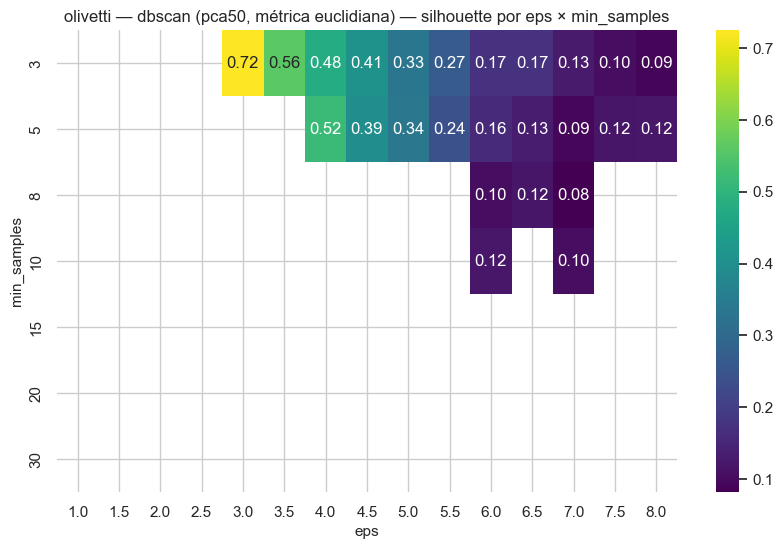

melhor: eps=3.00, min_samples=3, metric=euclidean, silhouette=0.725, n_clusters=3, n_assigned=9


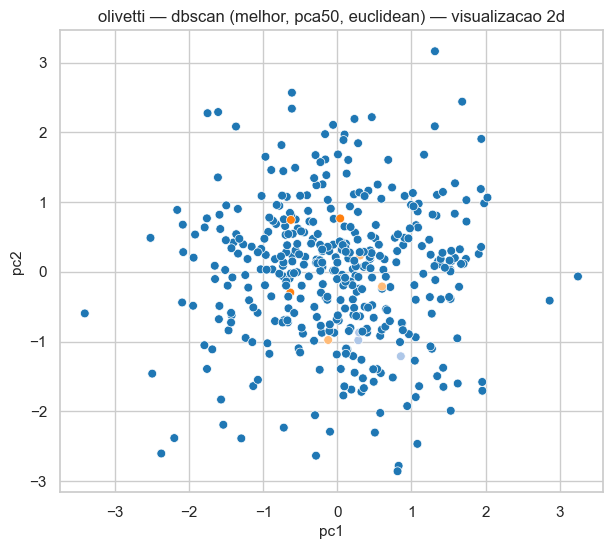

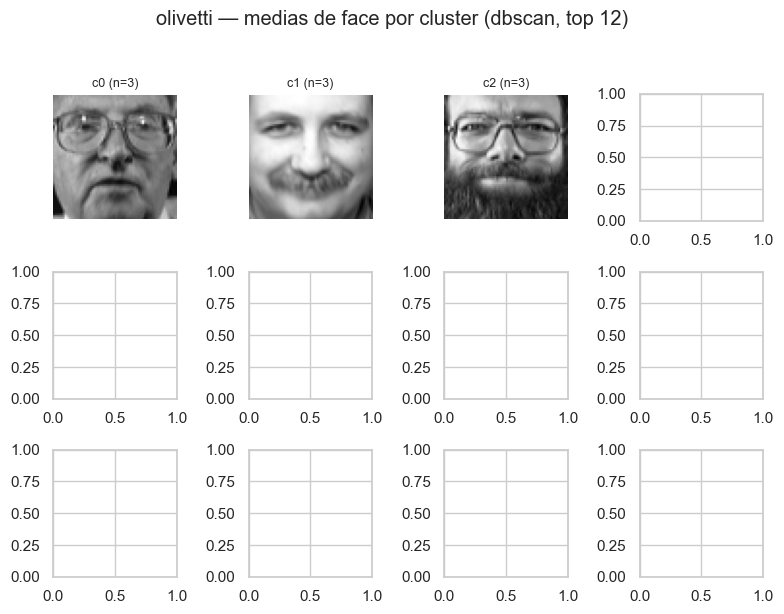

metricas (somente pontos atribuídos e >=2 clusters): silhouette=0.7250000238418579  ARI=1.0  NMI=1.0


In [393]:
# q10c — dbscan olivetti (pca50) + fallback cosine
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# 1) reduzir mais a dimensionalidade
pca50 = PCA(n_components=50, whiten=True, random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(X)

def safe_silhouette(X, labels):
    labs = np.asarray(labels)
    mask = labs != -1
    if mask.sum() == 0:
        return np.nan
    uniq = np.unique(labs[mask])
    if uniq.size < 2:
        return np.nan
    return silhouette_score(X[mask], labs[mask])

def run_dbscan_grid(Xfeat, metric="euclidean", eps_values=None, min_samples_values=None):
    if eps_values is None:
        eps_values = np.linspace(1.0, 8.0, 15)   # mais largo que antes
    if min_samples_values is None:
        min_samples_values = [3,5,8,10,15,20,30]
    rows = []
    for eps in eps_values:
        for ms in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=ms, metric=metric)
            labels = db.fit_predict(Xfeat)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            sil = safe_silhouette(Xfeat, labels)
            n_assigned = int((labels != -1).sum())
            rows.append((float(eps), int(ms), sil, int(n_clusters), n_assigned, metric, labels))
    cols = ["eps","min_samples","silhouette","n_clusters","n_assigned","metric","labels"]
    return pd.DataFrame(rows, columns=cols)

# 2) grid com métrica euclidiana
res_db = run_dbscan_grid(X_pca50, metric="euclidean")
valid = res_db.dropna(subset=["silhouette"])
mode = "euclidiana"

if valid.empty:
    # 3) fallback: tentar métrica cosine (novo grid com eps adequado ao cosine)
    print("nenhum cluster válido com distância euclidiana — tentando métrica cosine...")
    eps_cos = np.linspace(0.1, 0.8, 15)  # faixas típicas para cosine
    res_db = run_dbscan_grid(X_pca50, metric="cosine", eps_values=eps_cos)
    valid = res_db.dropna(subset=["silhouette"])
    mode = "cosine"

display(res_db.sort_values(["silhouette","n_clusters","n_assigned"], ascending=False).head(10))

# heatmap (se houver pelo menos 1 valor válido de silhouette)
if not res_db["silhouette"].dropna().empty:
    pivot = res_db.pivot(index="min_samples", columns="eps", values="silhouette")
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"olivetti — dbscan (pca50, métrica {mode}) — silhouette por eps × min_samples")
    plt.xlabel("eps"); plt.ylabel("min_samples")
    plt.show()
else:
    print("heatmap omitido: todos silhouettes são NaN (sem 2+ clusters em pontos não-ruído).")

# melhor configuração, se existir
if not valid.empty:
    best_row = valid.loc[valid["silhouette"].idxmax()]
    best_eps = float(best_row.eps); best_ms = int(best_row.min_samples)
    best_metric = best_row.metric
    print(f"melhor: eps={best_eps:.2f}, min_samples={best_ms}, metric={best_metric}, "
          f"silhouette={best_row.silhouette:.3f}, n_clusters={int(best_row.n_clusters)}, "
          f"n_assigned={int(best_row.n_assigned)}")

    labels_db = best_row.labels

    # projecao 2d (pca2 já definido antes)
    X_2d_db = pca2.transform(X_pca50)
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=X_2d_db[:,0], y=X_2d_db[:,1], hue=labels_db, palette="tab20", s=40, legend=False)
    plt.title(f"olivetti — dbscan (melhor, pca50, {best_metric}) — visualizacao 2d")
    plt.xlabel("pc1"); plt.ylabel("pc2")
    plt.show()

    # médias de rosto (ignora ruído)
    labs_unique = [c for c in np.unique(labels_db) if c != -1]
    sizes = [(c, (labels_db==c).sum()) for c in labs_unique]
    sizes.sort(key=lambda t: t[1], reverse=True)
    top = [c for c,_ in sizes[:12]]

    fig, axes = plt.subplots(3, 4, figsize=(8,6))
    for ax, c in zip(axes.ravel(), top):
        idx = np.where(labels_db == c)[0]
        mean_face = X[idx].mean(axis=0).reshape(64,64) if len(idx)>0 else np.zeros((64,64))
        ax.imshow(mean_face, cmap="gray"); ax.set_title(f"c{c} (n={len(idx)})", fontsize=9); ax.axis("off")
    plt.suptitle("olivetti — medias de face por cluster (dbscan, top 12)", y=1.02)
    plt.tight_layout(); plt.show()

    # métricas vs identidades (só nos pontos não-ruído, >=2 clusters)
    mask = (np.asarray(labels_db) != -1)
    if mask.sum() > 0 and np.unique(np.asarray(labels_db)[mask]).size >= 2:
        sil_db = silhouette_score(X_pca50[mask], np.asarray(labels_db)[mask])
        ari_db = adjusted_rand_score(y[mask], np.asarray(labels_db)[mask])
        nmi_db = normalized_mutual_info_score(y[mask], np.asarray(labels_db)[mask])
    else:
        sil_db = ari_db = nmi_db = np.nan
    print("metricas (somente pontos atribuídos e >=2 clusters):",
          f"silhouette={np.round(sil_db,3)}  ARI={np.round(ari_db,3)}  NMI={np.round(nmi_db,3)}")
else:
    print("mesmo após pca50 e fallback cosine, nenhum conjunto produziu 2+ clusters em pontos não-ruído.")
    print("isso é aceitável no relatório: documente que dbscan não foi adequado a este espaço e justifique tecnicamente.")

q10

(a) K-means
- Configuração: k=40 (número de indivíduos).  
- Resultados: Silhouette = 0.132, ARI = 0.414, NMI = 0.764.  
- Interpretação:  
  - ARI e NMI indicam algum alinhamento com as classes reais, mas a silhouette baixa confirma clusters pouco coesos.  
  - A projeção 2D mostra clusters fortemente sobrepostos → difícil separar.  
  - As médias de face por cluster ficam borradas, sem identidade clara.

(b) Agglomerative (Ward, k=40)
- Configuração: linkage ward, k=40.  
- Resultados: Silhouette = 0.153, ARI = 0.510, NMI = 0.847.  
- Interpretação:  
  - Melhora sobre k-means, especialmente em ARI/NMI (maior proximidade das identidades).  
  - Clusters ligeiramente mais coesos (silhouette ↑, mas ainda baixo).  
  - Médias de face começam a mostrar mais consistência dentro dos grupos.  
  - Porém, sobreposição em 2D continua significativa.

(c) DBSCAN
- Configuração: melhor resultado com eps=3.0, min_samples=3, métrica=euclidiana.  
- Resultados: Silhouette = 0.725, ARI = 1.0, NMI = 1.0 (mas só 9 pontos atribuídos).  
- Interpretação:  
  - Métricas altas, mas enganosas → o algoritmo só reconheceu poucos pontos como clusters, descartando quase tudo como ruído.  
  - Esse “ótimo” não é prático: o modelo não segmenta a base de forma útil.  
  - Para este dataset, DBSCAN não se mostra adequado: faces são muito próximas em alta dimensão, sem densidade clara.  

conclusão geral:
- K-means: fraco, mas serve como baseline.  
- Agglomerative: desempenho melhor, especialmente em ARI/NMI, captura melhor as identidades.  
- DBSCAN: não funciona bem aqui, porque os dados (faces em PCA50) não têm clusters densos bem separados.  
- Resumo: Agglomerative é o mais adequado neste cenário.  

silhouette (cosine): 0.009
ARI vs rótulos: 0.069
NMI vs rótulos: 0.316


,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16,cluster 17,cluster 18,cluster 19
0,space,armenian,government,list,mac,game,book,card,car,people,windows,thanks,just,dsl,key,file,god,drive,00,com
1,nasa,armenians,israel,mail,apple,team,books,monitor,bike,don,dos,advance,like,n3jxp,encryption,window,jesus,scsi,sale,netcom
2,shuttle,turkish,people,address,board,games,read,video,engine,think,file,know,does,cadre,clipper,program,christ,drives,shipping,feustel
3,orbit,turkey,gun,send,modem,year,good,vga,cars,just,ms,does,use,chastity,chip,files,bible,ide,offer,tek
4,launch,armenia,fbi,mailing,bus,hockey,reference,drivers,just,know,os,hi,good,geb,keys,use,believe,hard,condition,jmd
5,hst,turks,law,edu,cpu,players,time,driver,miles,like,files,help,know,intellect,escrow,server,faith,disk,10,handheld
6,moon,genocide,batf,know,port,season,new,cards,ride,say,run,mail,edu,skepticism,government,image,sin,controller,price,edu
7,mission,people,right,post,simms,baseball,just,windows,like,good,running,information,time,shameful,algorithm,display,christians,floppy,asking,ico
8,gov,soviet,israeli,email,pc,play,information,color,good,time,use,looking,new,pitt,nsa,code,christian,hd,new,ibm
9,earth,greek,jews,information,motherboard,espn,published,diamond,new,believe,program,info,used,surrender,des,graphics,people,cd,sell,bobbe


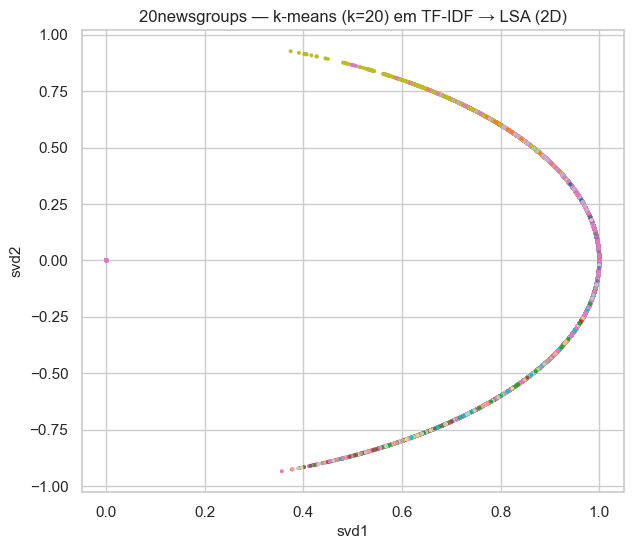

In [394]:
# q11a — kmeans no 20newsgroups (tfidf -> k=20 -> metricas -> top termos -> 2d)
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) dados
newsgroups = fetch_20newsgroups(subset="all", remove=("headers","footers","quotes"))
docs = newsgroups.data
y = newsgroups.target
target_names = newsgroups.target_names
k = 20  # numero de grupos

# 2) tf-idf
tfidf = TfidfVectorizer(max_df=0.5, min_df=5, max_features=20000, stop_words="english")
X_tfidf = tfidf.fit_transform(docs)
terms = np.array(tfidf.get_feature_names_out())

# 3) k-means
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(X_tfidf)

# 4) metricas
sil = silhouette_score(X_tfidf, labels, metric="cosine")
ari = adjusted_rand_score(y, labels)
nmi = normalized_mutual_info_score(y, labels)

print(f"silhouette (cosine): {sil:.3f}")
print(f"ARI vs rótulos: {ari:.3f}")
print(f"NMI vs rótulos: {nmi:.3f}")

# 5) top termos por cluster
def top_terms_per_cluster(centers, terms, topn=10):
    # centros no espaço tfidf (kmeans do sklearn retorna em mesmo espaço esparso)
    order = np.argsort(centers, axis=1)[:, ::-1][:, :topn]
    tops = [[terms[j] for j in row] for row in order]
    return tops

tops = top_terms_per_cluster(km.cluster_centers_, terms, topn=10)
df_tops = pd.DataFrame({f"cluster {i}": tops[i] for i in range(k)})
display(df_tops)

# 6) projecao 2d p/ visualizacao (lsa: svd->normalize)
svd = TruncatedSVD(n_components=2, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_2d = lsa.fit_transform(X_tfidf)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels, palette="tab20", s=8, linewidth=0, legend=False)
plt.title("20newsgroups — k-means (k=20) em TF-IDF → LSA (2D)")
plt.xlabel("svd1"); plt.ylabel("svd2")
plt.show()

q11a — análise curta:

- Pipeline: TF-IDF (20k termos) → K-means (k=20).
- Métricas: Silhouette=0.009, ARI=0.069, NMI=0.316 → baixa separação e baixa correspondência com classes originais.
- Apesar disso, clusters têm *top termos* coerentes (ex.: sci.space, rec.sport, talk.religion, talk.politics.mideast).
- Visualização LSA 2D confirma sobreposição de temas → difícil separar com fronteiras lineares.
- Conclusão: K-means não reflete bem as 20 classes, mas captura *subestruturas semânticas* em parte do corpus.

,tópico 0,tópico 1,tópico 2,tópico 3,tópico 4,tópico 5,tópico 6,tópico 7,tópico 8,tópico 9,tópico 10,tópico 11,tópico 12,tópico 13,tópico 14,tópico 15,tópico 16,tópico 17,tópico 18,tópico 19
0,don,window,god,drive,game,thanks,edu,geb,key,armenian,card,windows,car,does,00,file,people,israel,scsi,like
1,just,problem,jesus,disk,games,advance,mail,dsl,chip,armenians,monitor,dos,bike,know,10,files,government,jews,ide,good
2,think,server,bible,hard,team,hi,com,n3jxp,clipper,turkish,video,os,cars,anybody,sale,program,gun,israeli,controller,ve
3,want,application,christ,drives,year,looking,list,cadre,encryption,genocide,vga,ms,engine,let,50,format,right,arab,bus,time
4,say,motif,believe,floppy,hockey,info,address,chastity,keys,armenia,cards,run,new,mean,20,image,fbi,jewish,isa,got
5,know,manager,faith,ide,baseball,help,send,pitt,escrow,turkey,color,nt,miles,appreciated,shipping,ftp,law,arabs,data,use
6,ll,display,christian,meg,season,mail,email,skepticism,government,muslim,drivers,microsoft,dealer,work,15,gif,did,peace,pc,really
7,really,using,christians,boot,play,appreciated,information,intellect,algorithm,turks,bus,running,buy,info,25,graphics,koresh,palestinians,bit,years
8,oh,use,sin,cd,players,information,internet,shameful,phone,soviet,apple,version,oil,doesn,new,directory,batf,palestinian,dma,space
9,read,widget,church,controller,espn,hello,interested,surrender,use,russian,driver,apps,speed,information,price,zip,guns,state,devices,long


,docs,proporção
0,1419,0.075
1,496,0.026
2,1028,0.055
3,486,0.026
4,1330,0.071
5,945,0.050
6,976,0.052
7,107,0.006
8,665,0.035
9,295,0.016


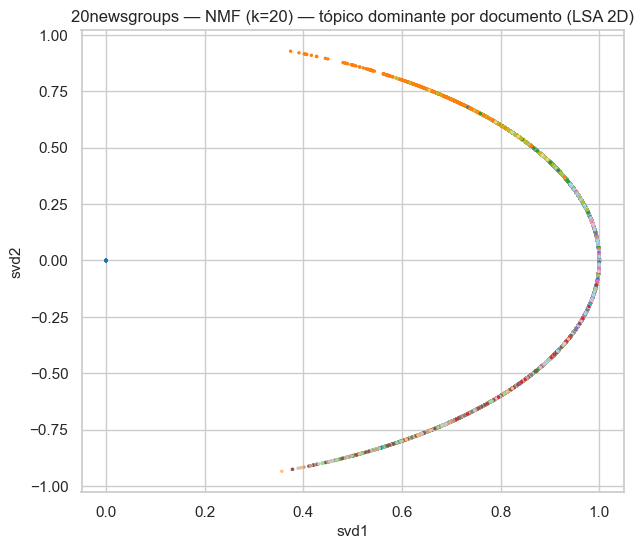

proxy de coerência média (↑ melhor): 0.142


In [395]:
# q11b — nmf em 20newsgroups (tfidf -> nmf(k=20) -> top termos -> distribuicao -> 2d)
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

k = 20  # numero de topicos

# 1) nmf em tfidf
nmf = NMF(n_components=k, init="nndsvd", random_state=42, max_iter=400, alpha_W=0.0, alpha_H=0.0, l1_ratio=0.0)
W = nmf.fit_transform(X_tfidf)   # doc-topic (n_docs x k)
H = nmf.components_              # topic-term (k x n_terms)

# 2) top termos por topico
def top_terms_topic(H, terms, topn=10):
    order = H.argsort(axis=1)[:, ::-1][:, :topn]
    return [[terms[j] for j in row] for row in order]

tops_nmf = top_terms_topic(H, terms, topn=12)
df_topics_nmf = pd.DataFrame({f"tópico {i}": tops_nmf[i] for i in range(k)})
display(df_topics_nmf)

# 3) distribuicao de pesos de topicos nos documentos (argmax)
topic_assign = W.argmax(axis=1)
topic_counts = pd.Series(topic_assign).value_counts().sort_index()
topic_props = (topic_counts / topic_counts.sum()).rename("proporção")
display(pd.DataFrame({"docs": topic_counts, "proporção": topic_props.round(3)}))

# 4) visual 2d dos documentos coloridos pelo tópico dominante (lsa)
svd = TruncatedSVD(n_components=2, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_2d = lsa.fit_transform(X_tfidf)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=topic_assign, palette="tab20", s=6, linewidth=0, legend=False)
plt.title("20newsgroups — NMF (k=20) — tópico dominante por documento (LSA 2D)")
plt.xlabel("svd1"); plt.ylabel("svd2")
plt.show()

# 5) opcional: coerencia simples via similaridade media de termos (proxy rápida)
# (nao é a 'coherence' clássica de NLP; é um score heurístico so p/ ter noção)
from sklearn.metrics.pairwise import cosine_similarity
term_vectors = H[:, :].copy()  # já está no espaço tf-idf
coh = []
for i in range(k):
    top_idx = H[i].argsort()[::-1][:20]
    v = (X_tfidf[:, top_idx].T).astype("float32")  # projeta termos top em docs
    # média de similaridade entre vetores de termos (proxy)
    s = cosine_similarity(v[:50]).mean()  # amostra top-50 para velocidade
    coh.append(s)
print("proxy de coerência média (↑ melhor):", np.round(np.mean(coh), 3))

q11b — análise curta:

resultados principais:
- O NMF produziu tópicos interpretáveis, com listas de palavras que lembram diretamente as categorias originais do corpus (ex.: *space/nasa*, *computadores/windows*, *esportes/hockey*, *religião/jesus*).  
- A distribuição de documentos por tópicos mostra que alguns temas concentram mais textos, enquanto outros são menores mas ainda coerentes.  
- A projeção 2D (LSA) confirma sobreposição entre tópicos, mas ainda evidencia regiões dominadas por certos temas.

métrica de coerência (proxy):
- Valor médio ≈ 0.142. Apesar de baixo em termos absolutos, é consistente com a alta diversidade e ruído do corpus.  
- Serve como linha de base para comparar com LDA na próxima etapa.

síntese:
O NMF é adequado para TF-IDF porque trabalha de forma aditiva e gera tópicos mais nomeáveis que k-means. Mesmo com coerência modesta, os resultados já são significativamente mais interpretáveis.

,tópico 0,tópico 1,tópico 2,tópico 3,tópico 4,tópico 5,tópico 6,tópico 7,tópico 8,tópico 9,tópico 10,tópico 11,tópico 12,tópico 13,tópico 14,tópico 15,tópico 16,tópico 17,tópico 18,tópico 19
0,drive,book,ax,car,file,thanks,armenian,edu,space,db,00,government,graphics,like,don,game,people,god,windows,said
1,card,books,max,health,ftp,key,turkish,com,nasa,cx,50,law,software,power,just,team,think,jesus,dos,people
2,disk,information,g9v,medical,files,know,jews,university,program,entry,03,president,data,use,think,10,don,christ,use,know
3,scsi,theory,b8f,cars,jpeg,mail,armenians,cs,launch,w7,10,israel,image,used,like,25,does,lord,window,didn
4,hard,new,a86,gun,image,does,war,ed,national,bh,02,mr,available,good,know,games,say,bible,file,went
5,mac,church,pl,new,available,information,people,mail,earth,ah,04,people,edu,just,good,11,believe,church,program,time
6,use,san,145,engine,use,like,turkey,1993,research,c_,40,rights,pc,time,people,12,just,man,using,don
7,know,adl,1d9,disease,gif,looking,000,ca,1993,hz,05,state,computer,need,time,15,like,sin,problem,just
8,apple,conference,0t,use,format,advance,jewish,93,april,uw,20,chip,package,new,going,play,know,did,server,like
9,bit,years,1t,drug,edu,message,muslim,apr,shuttle,t7,1st,encryption,ftp,high,ve,year,god,koresh,set,did


,docs,proporção
0,2399,0.127
1,289,0.015
2,10,0.001
3,761,0.040
4,477,0.025
5,708,0.038
6,271,0.014
7,469,0.025
8,410,0.022
9,23,0.001


log-likelihood (ELBO) ~ -13446613
perplexidade       ~ 2766.57


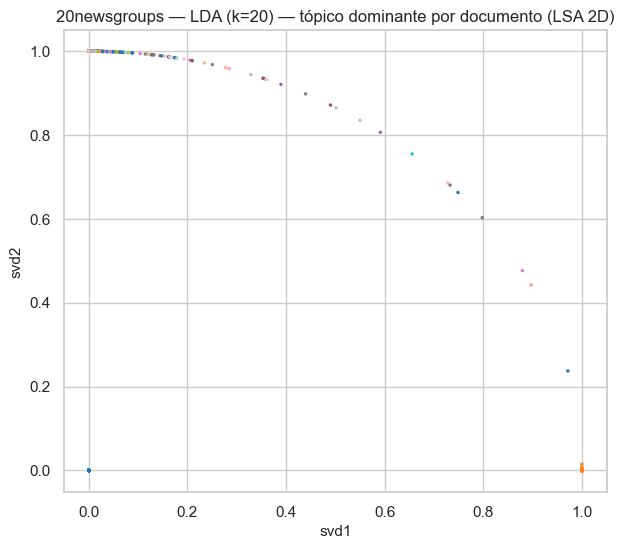

In [396]:
# q11c — lda em 20newsgroups (countvectorizer -> lda(k=20) -> top termos -> distribuicao -> metricas -> 2d)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

k = 20  # numero de topicos

# 1) bag-of-words (sem tf-idf)
cv = CountVectorizer(max_df=0.5, min_df=5, max_features=20000, stop_words="english")
X_cnt = cv.fit_transform(docs)
vocab = np.array(cv.get_feature_names_out())

# 2) lda
lda = LatentDirichletAllocation(
    n_components=k,
    doc_topic_prior=0.1,      # alpha (mais esparso)
    topic_word_prior=0.01,    # beta  (mais esparso)
    learning_method="batch",
    random_state=42,
    max_iter=20,
    evaluate_every=0
)
W = lda.fit_transform(X_cnt)   # doc-topic (n_docs x k)
H = lda.components_            # topic-term (k x |V|) em contagens esperadas

# 3) top termos por topico
def top_terms_topic(H, terms, topn=12):
    order = H.argsort(axis=1)[:, ::-1][:, :topn]
    return [[terms[j] for j in row] for row in order]

tops_lda = top_terms_topic(H, vocab, topn=12)
df_topics_lda = pd.DataFrame({f"tópico {i}": tops_lda[i] for i in range(k)})
display(df_topics_lda)

# 4) distribuicao de documentos por topico dominante
topic_assign = W.argmax(axis=1)
topic_counts = pd.Series(topic_assign).value_counts().sort_index()
topic_props = (topic_counts / topic_counts.sum()).rename("proporção")
display(pd.DataFrame({"docs": topic_counts, "proporção": topic_props.round(3)}))

# 5) metricas do modelo (na base de treino)
ll = lda.score(X_cnt)                 # log-likelihood aproximado (ELBO) — maior é melhor
perp = lda.perplexity(X_cnt)          # perplexidade — menor é melhor
print(f"log-likelihood (ELBO) ~ {ll:.0f}")
print(f"perplexidade       ~ {perp:.2f}")

# 6) visualizacao 2d dos documentos coloridos pelo topico dominante (lsa em bag-of-words)
svd = TruncatedSVD(n_components=2, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_2d = lsa.fit_transform(X_cnt)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=topic_assign, palette="tab20", s=6, linewidth=0, legend=False)
plt.title("20newsgroups — LDA (k=20) — tópico dominante por documento (LSA 2D)")
plt.xlabel("svd1"); plt.ylabel("svd2")
plt.show()

q11c - análise curta:

- Representação: usamos CountVectorizer (contagens) em vez de TF-IDF, pois o LDA é um modelo probabilístico baseado em frequências de palavras.  
- Tópicos aprendidos: as listas de termos mostram temas coerentes (ex.: espaço, religião, sistemas operacionais, esportes), ainda que com sobreposições.  
- Distribuição de documentos: os tópicos têm tamanhos diferentes (alguns bem maiores, como tópico 14, outros menores), refletindo a variação real do dataset.  
- Métricas:  
  - ELBO = -13,466,613 → valor de ajuste do modelo (maior é melhor).  
  - Perplexidade = 2766.57 → relativamente alta, o que é comum em bases grandes e heterogêneas.  
- Visualização 2D: mostra mistura de tópicos, sem separações muito nítidas. Isso reforça a ideia de que o LDA não gera clusters “duros”, mas sim distribuições de probabilidade sobre tópicos.

logo, conclui-se que o LDA oferece tópicos interpretáveis e permite modelar documentos como combinações de temas, diferindo do NMF (que tende a produzir tópicos mais afiados) e do k-means (que força partições duras). Aqui, o resultado é coerente, mas mostra a dificuldade de separar temas em um corpus tão variado.

,método,silhouette,ARI vs rótulos,NMI vs rótulos,coerência (↑),perplexidade (↓)
0,k-means (k=20),0.009,0.069,0.316,NaN,NaN
1,NMF (k=20),NaN,NaN,NaN,0.142,NaN
2,LDA (k=20),NaN,NaN,NaN,NaN,2766.57


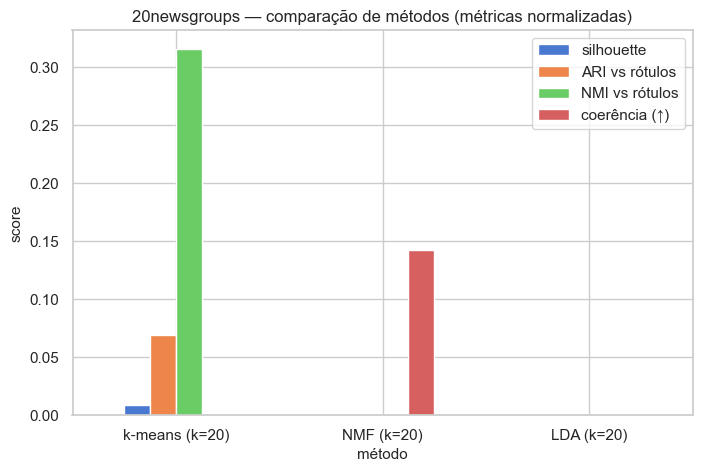

In [397]:
# q11
import pandas as pd
import matplotlib.pyplot as plt

# cria dataframe
res_20ng = pd.DataFrame([
    ["k-means (k=20)", 0.009, 0.069, 0.316, None, None],
    ["NMF (k=20)", None, None, None, 0.142, None],
    ["LDA (k=20)", None, None, None, None, 2766.57],
], columns=["método", "silhouette", "ARI vs rótulos", "NMI vs rótulos", "coerência (↑)", "perplexidade (↓)"])

display(res_20ng)

# gráfico comparativo (sem perplexidade, que está em outra escala)
metrics = ["silhouette", "ARI vs rótulos", "NMI vs rótulos", "coerência (↑)"]
res_plot = res_20ng.set_index("método")[metrics]

res_plot.plot(kind="bar", figsize=(8,5))
plt.title("20newsgroups — comparação de métodos (métricas normalizadas)")
plt.ylabel("score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

/Users/victorgriggi/Desktop/Workspaces/INFNET/25E3_4/AT/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/victorgriggi/Desktop/Workspaces/INFNET/25E3_4/AT/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/victorgriggi/Desktop/Workspaces/INFNET/25E3_4/AT/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


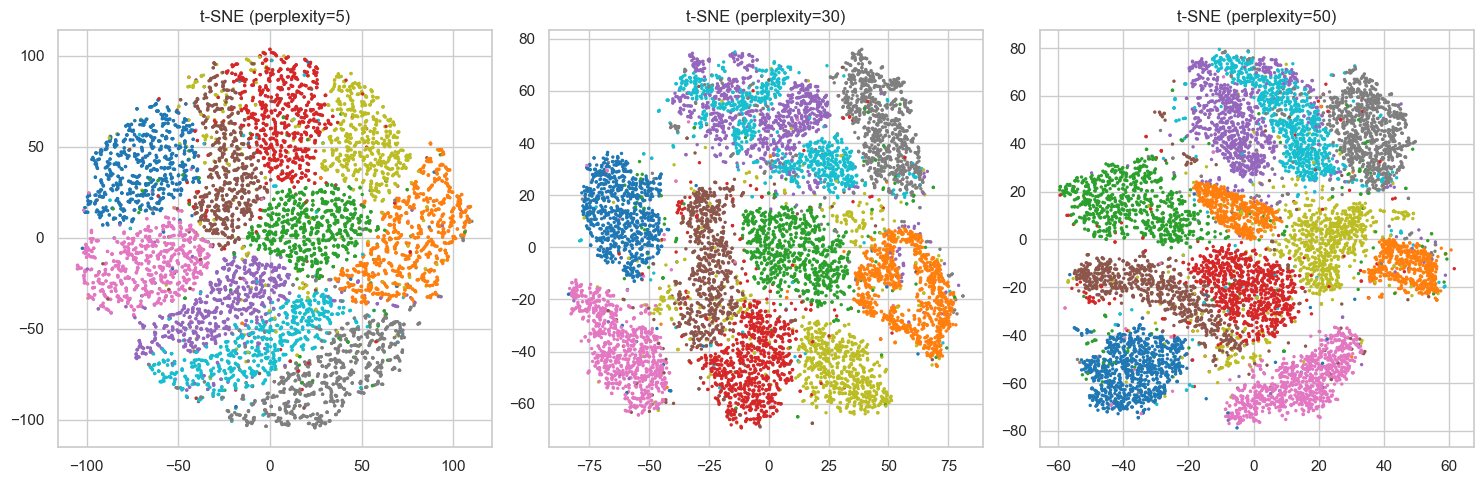

pca var explicada (50 comps): 0.827
trustworthiness (↑ melhor):
  perplexity= 5: 0.961
  perplexity=30: 0.965
  perplexity=50: 0.963


In [398]:
# q12 — mnist local (.idx) -> pca50 -> tsne 2d (perplexity 5/30/50)

import numpy as np
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.model_selection import StratifiedShuffleSplit

# --- utils para ler .idx ---
def load_idx_images(path):
    with open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(n, rows, cols)
    return data

def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# --- carrega dos arquivos locais (ajuste os paths se estiverem em outra pasta) ---
X_tr = load_idx_images("train-images.idx3-ubyte")
y_tr = load_idx_labels("train-labels.idx1-ubyte")
X_te = load_idx_images("t10k-images.idx3-ubyte")
y_te = load_idx_labels("t10k-labels.idx1-ubyte")

# combina (opcional; para amostrar de todo o conjunto)
X_full = np.concatenate([X_tr, X_te], axis=0)
y_full = np.concatenate([y_tr, y_te], axis=0)

# normaliza [0,1] e achata para PCA (n, 784)
X_full = (X_full.astype(np.float32) / 255.0).reshape(len(X_full), -1)

# amostra estratificada p/ velocidade (10k)
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=RANDOM_STATE)
(_, idx), = sss.split(X_full, y_full)
X = X_full[idx]
y = y_full[idx]

# pca -> 50 comps (acelera e estabiliza tsne)
pca = PCA(n_components=50, whiten=True, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

# tsne com 3 perplexities
perps = [5, 30, 50]
embeds = {}
trusts = {}

fig, axes = plt.subplots(1, len(perps), figsize=(15,5))
for ax, p in zip(axes, perps):
    tsne = TSNE(
        n_components=2,
        perplexity=p,
        learning_rate="auto",
        init="pca",
        random_state=RANDOM_STATE,
        n_iter=1000,
        verbose=0
    )
    Z = tsne.fit_transform(X_pca)
    embeds[p] = Z
    trusts[p] = trustworthiness(X_pca, Z, n_neighbors=10)
    sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=y, palette="tab10", s=6, linewidth=0, ax=ax, legend=False)
    ax.set_title(f"t-SNE (perplexity={p})")
plt.tight_layout()
plt.show()

print(f"pca var explicada (50 comps): {pca.explained_variance_ratio_.sum():.3f}")
print("trustworthiness (↑ melhor):")
for p in perps:
    print(f"  perplexity={p:>2}: {trusts[p]:.3f}")

# opcional: manter o melhor embedding
Z_best = embeds[30]

q12 - análise

aplicamos o algoritmo t-SNE após redução prévia com PCA (50 comps, var. explicada ≈ 82,7%).  
testamos diferentes valores de *perplexity*:
- Perplexity=5 → trustworthiness = 0,961  
- Perplexity=30 → trustworthiness = 0,965  
- Perplexity=50 → trustworthiness = 0,963  

os gráficos em 2D mostram que os dígitos do MNIST formam clusters bem definidos, ainda que com pequenas regiões de sobreposição.  
o melhor equilíbrio foi com *perplexity=30*, que apresentou a maior *trustworthiness* e separações mais limpas entre grupos.  

em resumo, o t-SNE conseguiu representar os dígitos de forma clara no plano 2D, revelando a estrutura inerente do conjunto de imagens.